# Notebook to "try" reproducing certification

This notebook intends to provide pieces to illustrate how to reproduce results from the "Mémoire de Certfication". However there are some limitations.

Some of the data used in the thesis are not available in the dataset and does not allow to have the exact dataset used during the certification. Therefore the results will be different.

Therefore, we will try to have a similar analysis but we will not be able to end-up with similar results.

### Data loading

We will be reusing the data that we clean during the morning of the datacamp.

Note that from the original dataset, we created three new columns:

- the age of the policy at the time of claim
- the delay of the claim
- the age of the client at the time of claim

Those columns were stored as `timedelta` (cf. [pandas documentation](https://pandas.pydata.org/docs/reference/api/pandas.Timedelta.html)) expressed in days. We reuse this format and express these quantity in days to have a numerical representation that does not require complicated processing later on.

In [1]:
import pandas as pd

df = pd.read_csv(
    "cleaner_dataframe.csv",
    parse_dates=[
        "Claim Incident date",
        "FE_Declaration_date",
        "Initial coverage date",
        "First claim decision date",
        "Last claim decisión date",
        "Policy Holder date of birth",
        "Age policy at claim",
    ],
    index_col=0,
)
df["Age policy at claim"] = pd.to_timedelta(df["Age policy at claim"]).dt.days
df["Delay declaration"] = pd.to_timedelta(df["Delay declaration"]).dt.days
df["Age client at claim"] = pd.to_timedelta(df["Age client at claim"]).dt.days
df

,Risk code,Claim Incident date,FE_Declaration_date,Initial coverage date,First claim decision date,Last claim decisión date,Insured amount,Initial_Instalment_Amount,Policy Holder date of birth,Age at signature,...,Trad_Refusal_reason,Refusal_Category,Claim_Status_Level_0,Refusal_Flag,Local Partner name categories,Insured NIF categories,Claim Number categories,Age policy at claim,Delay declaration,Age client at claim
7,13,2010-04-09,2010-07-06,2010-02-19,2010-07-14,2011-01-14,790.02,131.67,1946-02-03,64,...,Waiting Period,Administrative,Claim refused,Yes,4,3,8935,49,88,23441
9,1,2010-01-22,2010-02-22,2010-01-11,2010-03-02,2011-03-24,6000.00,111.22,1946-08-18,63,...,Waiting Period,Administrative,Claim accepted after refusal,Yes,35,4,59206,11,31,23168
11,3,2009-11-16,2011-06-27,2009-07-21,2011-07-07,2012-01-11,3337.08,73.60,1946-09-28,62,...,Waiting Period,Administrative,Claim refused,Yes,35,6,65416,118,588,23060
12,13,2010-04-09,2010-05-18,2009-08-11,2010-05-20,2010-11-29,610.74,101.79,1947-02-21,62,...,Waiting Period,Administrative,Claim refused,Yes,3,7,8072,241,39,23058
14,13,2009-07-31,2010-07-27,2009-07-30,2010-08-03,2011-02-04,599.70,99.95,1947-09-11,61,...,Waiting Period,Administrative,Claim refused,Yes,15,9,6499,1,361,22604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
126804,13,2015-11-18,2015-12-31,2014-11-17,2016-01-04,2016-01-04,963.36,160.56,1995-07-18,19,...,NaN,NaN,Being processed,No,4,74030,50532,366,43,7428
126805,13,2015-12-15,2016-01-29,2015-11-30,2016-02-01,2016-02-01,882.18,147.03,1996-01-02,19,...,NaN,NaN,Being processed,No,4,74031,51111,15,45,7287
126806,5,2017-01-23,2017-02-02,2016-09-23,2017-02-03,2017-02-09,996.90,166.15,1996-10-09,19,...,NaN,NaN,Being processed,No,23,74032,54535,122,10,7411
126807,13,2017-02-02,2017-03-02,2016-11-04,2017-03-06,2017-03-06,550.98,91.83,1997-01-23,19,...,NaN,NaN,Being processed,No,4,74033,54667,90,28,7315


We can check that opening the CSV file when as we expected.

In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56371 entries, 7 to 126808
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   Risk code                      56371 non-null  int64         
 1   Claim Incident date            56371 non-null  datetime64[ns]
 2   FE_Declaration_date            56371 non-null  datetime64[ns]
 3   Initial coverage date          56371 non-null  datetime64[ns]
 4   First claim decision date      56371 non-null  datetime64[ns]
 5   Last claim decisión date       56353 non-null  datetime64[ns]
 6   Insured amount                 56371 non-null  float64       
 7   Initial_Instalment_Amount      56371 non-null  float64       
 8   Policy Holder date of birth    56371 non-null  datetime64[ns]
 9   Age at signature               56371 non-null  int64         
 10  Sexo                           56371 non-null  object        
 11  Refused decisi

As we can see, dates have been parsed properly and our three new columns are stored with integral data types.

Now, we will split the dataset into a vector containing whether or not a claim was refused and a matrix containing the features. For this matter, we will store the name of the features and the name of the target.

Note that we exclude the date from the features used because we created the last three columns using them.

In [3]:
feature_names = [
    "Risk code",
    "Insured amount",
    "Initial_Instalment_Amount",
    "Age at signature",
    "Sexo",
    "Age policy at claim",
    "Delay declaration",
    "Age client at claim",
]
target_names = "Refusal_Flag"
X, y = df[feature_names], df[target_names]

In [4]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56371 entries, 7 to 126808
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Risk code                  56371 non-null  int64  
 1   Insured amount             56371 non-null  float64
 2   Initial_Instalment_Amount  56371 non-null  float64
 3   Age at signature           56371 non-null  int64  
 4   Sexo                       56371 non-null  object 
 5   Age policy at claim        56371 non-null  int64  
 6   Delay declaration          56371 non-null  int64  
 7   Age client at claim        56371 non-null  int64  
dtypes: float64(2), int64(5), object(1)
memory usage: 3.9+ MB


Thus, we have 7 features to learn from.

### Aside note regarding categorical features

As we saw during the lecture, categorical features need particular attention: these features are necessarly numerical values while machine learning algorithm only deal with such numerical values. We therefore needs to encode those values to a numerical representation.

However, this representation needs to be chose with care. Indeed, it will depend on the type of predictive model used later on.

Here, we recall the two main type of categorical encoders used. We also recall with which model one wants to use them.

First let's define in a Python list, which columns can be considered categorical:

In [5]:
categorical_columns = ["Risk code", "Sexo"]

Indeed, we have two categorical features. While it is obvious that `"Sexo"` is such a categorical features, it is a less obvious for `"Risk code"` since it is represented already by some integral values. However, the name indicate us that this is a "code" and therefore composed of discrete values.

We should therefore include this column in our processing.

In [6]:
X_categorical = X[categorical_columns]

#### Ordinal encoding

The simplest encoding that we can use is to replace each category by an integer. We will therefore have categories represented by values between `[0, n_categories - 1]`. We will illustrate below such encoding:

In [7]:
from sklearn.preprocessing import OrdinalEncoder

encoder = OrdinalEncoder()
X_train_encoded = encoder.fit_transform(X_categorical)
X_train_encoded

array([[3., 1.],
       [0., 1.],
       [1., 1.],
       ...,
       [2., 1.],
       [3., 1.],
       [3., 1.]])

The output of scikit-learn will be a NumPy array. We can create a pandas `DataFrame` using the `get_feature_names_out` method to generate the column names. This method allows to track complex column transformation in scikit-learn `Pipeline` as well.

In [8]:
X_train_encoded = pd.DataFrame(
    X_train_encoded, columns=encoder.get_feature_names_out()
)
X_train_encoded

,Risk code,Sexo
0,3.0,1.0
1,0.0,1.0
2,1.0,1.0
3,3.0,1.0
4,3.0,1.0
...,...,...
56366,3.0,0.0
56367,3.0,0.0
56368,2.0,1.0
56369,3.0,1.0


We observe that each categories is therefore encoded with an integer. We could check the correspondence by looking at the fitted attributes of the encoder.

In [9]:
for col_name, col_categories in zip(
    encoder.get_feature_names_out(),
    encoder.categories_
):
    print(f"For feature named {col_name!r}")
    print()
    for code, cat in enumerate(col_categories):
        print(f"\tCategory {cat!r} mapped to {code}")
    print()

For feature named 'Risk code'

	Category 1 mapped to 0
	Category 3 mapped to 1
	Category 5 mapped to 2
	Category 13 mapped to 3
	Category 79 mapped to 4

For feature named 'Sexo'

	Category 'Femme' mapped to 0
	Category 'Homme' mapped to 1



This type of encoder is imposing an ordering and it is not always adequate for linear model in which we don't want to impose such modeling. It is therefore the encoder of choice used in tree-based models.

#### One-hot encoding

When using a linear model, we will be "usually" interested of having an independence between categories. Therefore, with such models, `OneHotEncoder` is an interesting encoder. We will reproduce the previous experiment to show what this encoder does.

In [10]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
X_train_encoded = encoder.fit_transform(X_categorical)
X_train_encoded

<56371x7 sparse matrix of type '<class 'numpy.float64'>'
	with 112742 stored elements in Compressed Sparse Row format>

In [11]:
X_train_encoded = pd.DataFrame(
    X_train_encoded.A, columns=encoder.get_feature_names_out()
)
X_train_encoded

,Risk code_1,Risk code_3,Risk code_5,Risk code_13,Risk code_79,Sexo_Femme,Sexo_Homme
0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
1,1.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,1.0,0.0,0.0,1.0
4,0.0,0.0,0.0,1.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...
56366,0.0,0.0,0.0,1.0,0.0,1.0,0.0
56367,0.0,0.0,0.0,1.0,0.0,1.0,0.0
56368,0.0,0.0,1.0,0.0,0.0,0.0,1.0
56369,0.0,0.0,0.0,1.0,0.0,0.0,1.0


We see that each category becomes a column and that an indicator 0/1 is used to indicate whether or not we deal with the category for this sample.

### Creating basic predictive models

Now, we can design some predictive model. Here, we will develop 3 predictive models:

- a dummy classifier that is not going to use `X` to make any prediction. It is not an interesting model but it provides a kind of baseline.
- a linear model with an adequate preprocessing. Indeed, the preprocessing has to contain a scaler and a one-hot encoder.
- a gradient boosting decision trees model. This model should use an ordinal encoder in its preproceesing stage.

Let's define the three models.

#### Dummy classifier

In [12]:
from sklearn.dummy import DummyClassifier

dummy_model = DummyClassifier()

#### Linear model

In [13]:
# define the name of the numerical columns (the ones that are not categorical)
numerical_columns = X.columns.difference(categorical_columns).tolist()
numerical_columns

['Age at signature',
 'Age client at claim',
 'Age policy at claim',
 'Delay declaration',
 'Initial_Instalment_Amount',
 'Insured amount']

In [14]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

preprocessor = ColumnTransformer(transformers=[
    ("categorical_processor", OneHotEncoder(drop="if_binary"), categorical_columns),
    ("numerical_processor", StandardScaler(), numerical_columns),
])
linear_model = Pipeline(steps=[
    ("preprocessor", preprocessor), ("classifier", LogisticRegression())
])
linear_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('categorical_processor',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['Risk code', 'Sexo']),
                                                 ('numerical_processor',
                                                  StandardScaler(),
                                                  ['Age at signature',
                                                   'Age client at claim',
                                                   'Age policy at claim',
                                                   'Delay declaration',
                                                   'Initial_Instalment_Amount',
                                                   'Insured amount'])])),
                ('classifier', LogisticRegression())])

#### Tree-based model

In [15]:
from sklearn.ensemble import HistGradientBoostingClassifier

preprocessor = ColumnTransformer(transformers=[
        ("categorical_processor", OrdinalEncoder(), categorical_columns),
    ],
    remainder="passthrough",
)
hgbdt_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("classifier", HistGradientBoostingClassifier(random_state=0)),
])
hgbdt_model

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('categorical_processor',
                                                  OrdinalEncoder(),
                                                  ['Risk code', 'Sexo'])])),
                ('classifier', HistGradientBoostingClassifier(random_state=0))])

### Evaluating these models with cross-validation

Now that we define these models, we have to evaluate them. For this purpose, we need to use a metric. However, our problem is imbalanced:

In [16]:
y.value_counts(normalize=True)

No     0.733249
Yes    0.266751
Name: Refusal_Flag, dtype: float64

Indeed, the proportion of `"No"` and `"Yes"` is not 50-50. We therefore need to select a proper statistical metric. Here, we can use the ROC-AUC.

We also need to choose a cross-validation strategy. A stratified k-fold cross-validation is a good choice in this case to be sure that the ratio of the classes is preserved in each of the splits. In addition, we will shuffle the data. I will come back on this point.

Let's evaluate the dummy classifier.

In [17]:
from sklearn.model_selection import cross_validate, StratifiedKFold

cv = StratifiedKFold(n_splits=30, shuffle=True)
cv_results = cross_validate(
    dummy_model, X, y,
    return_train_score=True,
    scoring=["roc_auc"],
    n_jobs=-1,
    cv=cv,
)
cv_results = pd.DataFrame(cv_results)
cv_results = cv_results[["train_roc_auc", "test_roc_auc"]]
print(
    f"""Dummy classifier results in terms of ROC-AUC:

    Training: {cv_results['train_roc_auc'].mean():.3f} +/- {cv_results['train_roc_auc'].std():.3f}
    Testing: {cv_results['test_roc_auc'].mean():.3f} +/- {cv_results['test_roc_auc'].std():.3f}
    """
)

Dummy classifier results in terms of ROC-AUC:

    Training: 0.500 +/- 0.000
    Testing: 0.500 +/- 0.000
    


It is not a surprised that this model outputs an average AUC of 0.5 on both training and testing. Let's check if a linear model provides better statistics.

In [18]:
cv_results = cross_validate(
    linear_model, X, y,
    return_train_score=True,
    scoring=["roc_auc"],
    n_jobs=-1,
    cv=cv,
)
cv_results = pd.DataFrame(cv_results)
cv_results = cv_results[["train_roc_auc", "test_roc_auc"]]
print(
    f"""Linear model results in terms of ROC-AUC:

    Training: {cv_results['train_roc_auc'].mean():.3f} +/- {cv_results['train_roc_auc'].std():.3f}
    Testing: {cv_results['test_roc_auc'].mean():.3f} +/- {cv_results['test_roc_auc'].std():.3f}
    """
)

Linear model results in terms of ROC-AUC:

    Training: 0.630 +/- 0.001
    Testing: 0.630 +/- 0.015
    


It seems that this is a bit better. We can also see that the model does not overfit since the results are similar on the training and testing set. Let's check the last model type of model:

In [19]:
cv_results = cross_validate(
    hgbdt_model, X, y,
    return_train_score=True,
    scoring=["roc_auc"],
    n_jobs=-1,
    cv=cv,
)
cv_results = pd.DataFrame(cv_results)
print(
    f"""HGBDT model results in terms of ROC-AUC:

    Training: {cv_results['train_roc_auc'].mean():.3f} +/- {cv_results['train_roc_auc'].std():.3f}
    Testing: {cv_results['test_roc_auc'].mean():.3f} +/- {cv_results['test_roc_auc'].std():.3f}
    """
)

HGBDT model results in terms of ROC-AUC:

    Training: 0.775 +/- 0.005
    Testing: 0.742 +/- 0.013
    


We observe that this model is better than the previous one. we can see that there is a small overfitting since the model is performing worse on the testing set than on the training set.

### Why it did not work for me

During the datacamp, we never got to the above results: it was much worse. One reason is linked to `shuffle=True` used in the cross-validation. Let's repeat the previous experiment without any shuffling:

In [20]:
cv = StratifiedKFold(n_splits=30, shuffle=False)
cv_results = cross_validate(
    hgbdt_model, X, y,
    return_train_score=True,
    scoring=["roc_auc"],
    n_jobs=-1,
    cv=cv,
)
cv_results = pd.DataFrame(cv_results)
print(
    f"""HGBDT model results in terms of ROC-AUC:

    Training: {cv_results['train_roc_auc'].mean():.3f} +/- {cv_results['train_roc_auc'].std():.3f}
    Testing: {cv_results['test_roc_auc'].mean():.3f} +/- {cv_results['test_roc_auc'].std():.3f}
    """
)

HGBDT model results in terms of ROC-AUC:

    Training: 0.780 +/- 0.009
    Testing: 0.530 +/- 0.232
    


We see that now the results are much worse. We even see that the testing is below 0.5 (meaning it is worse than random guessing!).

Usually, this indicates that the data are stored with a type of ordering. Here, breaking this strucutre starts to make our model predicts well. In practice, we should check what is the meaning of this ordering and if we should this structure in the data should exist or not. It will allow us to know if we should shuffle or not the data. You can have a look at this concrete example where I have a clear understanding of the data: https://inria.github.io/scikit-learn-mooc/python_scripts/cross_validation_grouping.html

### Reproducing ROC curve

In the thesis, the structure was broken to report the results because a single train-test split was used with shuffling. We can reproduce the ROC curve using such approach:

In [21]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, test_size=0.2, random_state=0
)

In [22]:
dummy_model.fit(X_train, y_train)
linear_model.fit(X_train, y_train)
_ = hgbdt_model.fit(X_train, y_train)

Now we can use the plotting tool from scikit-learn to plot the ROC curve

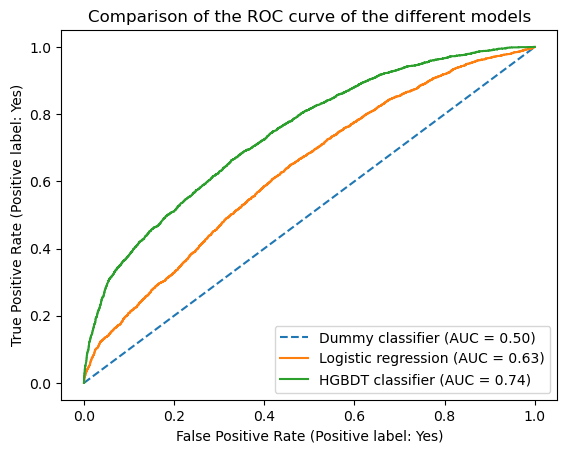

In [23]:
from sklearn.metrics import RocCurveDisplay

disp = RocCurveDisplay.from_estimator(
    dummy_model, X_test, y_test, name="Dummy classifier", linestyle="--"
)
RocCurveDisplay.from_estimator(
    linear_model, X_test, y_test, name="Logistic regression", ax=disp.ax_
)
RocCurveDisplay.from_estimator(
    hgbdt_model, X_test, y_test, name="HGBDT classifier", ax=disp.ax_
)
_ = disp.ax_.set_title(
    "Comparison of the ROC curve of the different models"
)

We more or less obtain the results show in the tesis.

### Permutation importance

Here, we show how to plot the feature importances by using the permutation approach.

In [24]:
from sklearn.inspection import permutation_importance

importances = permutation_importance(
    hgbdt_model, X_test, y_test, scoring="roc_auc"
)
importances = pd.DataFrame(
    importances.importances.T,
    columns=hgbdt_model[:-1].get_feature_names_out(),
)

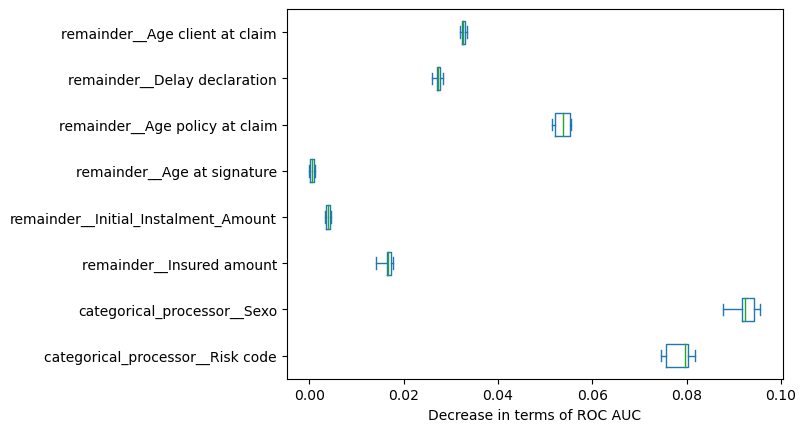

In [25]:
ax = importances.plot.box(vert=False, whis=10)
_ = ax.set_xlabel("Decrease in terms of ROC AUC")

### Conclusion

The thesis is showing the "Economic loss". We cannot construct this loss because we are missing some information. However, it comes back to assign a cost to a prediction depending if we do a mistake or not.

In the thesis, the cost depend on some external values that we don't have access. If we would have these access, we could there fore compute the cost, for all the possible threshold of used for the ROC curve and have a business oriented metric which is more maningful than the ROC curve.